In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [2]:
import pandas as pd
data = pd.read_csv("/kaggle/input/insurance/insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder


I need to convert my data from categorical values to numerical values.

In [4]:
label_encoder_sex = LabelEncoder()
data['sex'] = label_encoder_sex.fit_transform(data['sex'])

In [5]:
label_encoder_smoker = LabelEncoder()
data['smoker'] = label_encoder_smoker.fit_transform(data['smoker'])

In [6]:
data['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [7]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder_region = OneHotEncoder()
region_encoder = onehot_encoder_region.fit_transform(data[['region']])
region_encoder

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1338 stored elements and shape (1338, 4)>

In [8]:
column_region = onehot_encoder_region.get_feature_names_out(['region'])
column_region

array(['region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

In [9]:
region_encoder_df=pd.DataFrame(region_encoder.toarray(),columns=column_region)
region_encoder_df

,region_northeast,region_northwest,region_southeast,region_southwest
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
1333,0.0,1.0,0.0,0.0
1334,1.0,0.0,0.0,0.0
1335,0.0,0.0,1.0,0.0
1336,0.0,0.0,0.0,1.0


In [10]:
data = pd.concat([data.drop('region',axis=1),region_encoder_df],axis=1)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0


In [11]:
data.isnull().sum()

age                 0
sex                 0
bmi                 0
children            0
smoker              0
charges             0
region_northeast    0
region_northwest    0
region_southeast    0
region_southwest    0
dtype: int64

In [12]:
data.corr()['charges']

age                 0.299008
sex                 0.057292
bmi                 0.198341
children            0.067998
smoker              0.787251
charges             1.000000
region_northeast    0.006349
region_northwest   -0.039905
region_southeast    0.073982
region_southwest   -0.043210
Name: charges, dtype: float64

In [13]:
x=data.drop('charges',axis=1)
y=data['charges']
#splitting the data into train and test 
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
#sacling our data to fit in the model
scalar = StandardScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

In [14]:
x

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,0.0,0.0,0.0,1.0
1,18,1,33.770,1,0,0.0,0.0,1.0,0.0
2,28,1,33.000,3,0,0.0,0.0,1.0,0.0
3,33,1,22.705,0,0,0.0,1.0,0.0,0.0
4,32,1,28.880,0,0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,0.0,1.0,0.0,0.0
1334,18,0,31.920,0,0,1.0,0.0,0.0,0.0
1335,18,0,36.850,0,0,0.0,0.0,1.0,0.0
1336,21,0,25.800,0,0,0.0,0.0,0.0,1.0


In [15]:
x_train.shape

(1070, 9)

ANN regression

In [16]:
!pip install keras-tuner --quiet


In [17]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy

2025-05-31 16:50:35.623400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748710235.864015      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748710235.933158      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_13/1046821010.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


by using the keras-tuner , I have experiment with my model. this library helps in finding the best values for our models.

In [18]:
def build_model(hp):
    model = Sequential()
    counter=0
    for i in range(hp.Int('num_layer',min_value=1,max_value=9)):

        if counter == 0:
            model.add(Dense(hp.Int('unit'+str(i),min_value=8,max_value=100),activation=hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid']),input_dim=9))
            model.add(Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        else:
             model.add(Dense(hp.Int('unit'+str(i),min_value=8,max_value=128),activation=hp.Choice('activation'+str(i),values=['relu','tanh','sigmoid'])))
             model.add(Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
        counter+=1
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer=hp.Choice('optimizer',values=['adam','sgd','rmsprop','adadelta']),loss='mse',metrics=['accuracy'])
    return model

In [19]:
tuner = kt.RandomSearch(build_model,objective='val_accuracy',max_trials=4,directory='mydir',project_name='1_appt')

2025-05-31 16:50:49.468865: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
tuner.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Trial 4 Complete [00h 00m 07s]
val_accuracy: 0.0

Best val_accuracy So Far: 0.0
Total elapsed time: 00h 00m 18s


In [21]:
tuner.get_best_hyperparameters()[0].values

{'num_layer': 5,
 'unit0': 67,
 'activation0': 'sigmoid',
 'dropout0': 0.6,
 'optimizer': 'sgd',
 'unit1': 8,
 'activation1': 'relu',
 'dropout1': 0.1,
 'unit2': 8,
 'activation2': 'relu',
 'dropout2': 0.1,
 'unit3': 8,
 'activation3': 'relu',
 'dropout3': 0.1,
 'unit4': 8,
 'activation4': 'relu',
 'dropout4': 0.1}

In [22]:
# Creating the model 
model = Sequential()
model.add(Dense(128,activation='relu',input_shape=(x_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer='Adam',loss='mse',metrics=['accuracy'])

In [25]:
## Set up the Tensorboard
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True)

In [27]:
history = model.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),callbacks=[tensorboard_callback,early_stopping])

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0000e+00 - loss: 305850624.0000 - val_accuracy: 0.0000e+00 - val_loss: 323228064.0000
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 336714528.0000 - val_accuracy: 0.0000e+00 - val_loss: 321876096.0000
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 329861216.0000 - val_accuracy: 0.0000e+00 - val_loss: 315718912.0000
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 300833280.0000 - val_accuracy: 0.0000e+00 - val_loss: 296831328.0000
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 272493088.0000 - val_accuracy: 0.0000e+00 - val_loss: 254534992.0000
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 249368416.0000 - val_accuracy: 0.0000e+00 - val_loss: 184814336.0000
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 166524368.0

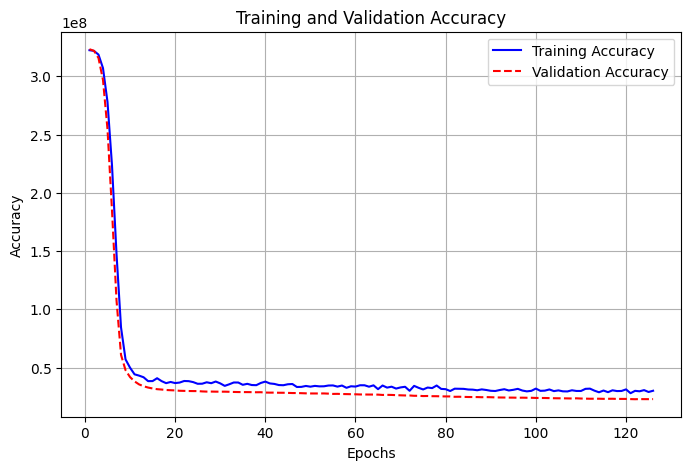

In [28]:
import matplotlib.pyplot as plt
hist_dict = history.history
acc = hist_dict['loss']
val_acc = hist_dict['val_loss']
epochs = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Predict on test data (or any input)
predictions = model.predict(x_test)  # X_test must match input shape used in training

# Print the first few predictions
print(predictions[:5])


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[10267.794 ]
 [ 5951.4917]
 [34769.56  ]
 [10525.429 ]
 [27378.879 ]]


In [30]:
## Actual prediction 
import numpy as np

# Create a single sample with correct shape (1, 9)
sample = np.array([[19, 0, 27.900, 0, 1, 0.0, 0.0, 0.0, 1.0]])

# Predict using your trained model
prediction = model.predict(sample)

# Output the predicted value
print("Predicted value:", prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted value: 298242.56
